In [1]:
import pandas as pd

# Load CSV file
Dataset_Train = pd.read_csv('F:/UOC/Level 4/Machine learning/Data analysis project 2/Dataset_Train_Final.csv')
Dataset_Test = pd.read_csv('F:/UOC/Level 4/Machine learning/Data analysis project 2/Dataset_Test_Final.csv')

# Display first 5 rows
Dataset_Train.head()
Dataset_Test.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Multivariate_Outlier
0,Male,No,42,Yes,Artist,8.0,Low,1.0,Cat_6,A,False
1,Male,Yes,43,Yes,Artist,2.0,Average,4.0,Cat_3,C,False
2,Female,Yes,59,No,Marketing,1.0,Average,4.0,Cat_1,D,False
3,Female,Yes,65,No,Engineer,1.0,Average,3.0,Cat_6,A,False
4,Female,No,69,Yes,Lawyer,1.0,Low,5.0,Cat_6,D,False


In [2]:
Dataset_Train.drop("Multivariate_Outlier", axis=1, inplace=True)

In [3]:
Dataset_Test.drop("Multivariate_Outlier", axis=1, inplace=True)

In [4]:
Dataset_Train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,36,Yes,Artist,0.0,Low,1.0,Cat_6,A
1,Male,No,25,Yes,Doctor,6.0,Low,1.0,Cat_2,D
2,Male,No,61,Yes,Artist,1.0,Low,1.0,Cat_6,B
3,Male,No,33,Yes,Homemaker,1.0,Low,1.0,Cat_6,D
4,Male,Yes,51,Yes,Engineer,1.0,Low,2.0,Cat_6,B


reducing the categoties of  profession variable

In [5]:
# Step 1: View the frequency of each profession
profession_counts = Dataset_Train['Profession'].value_counts()
print(profession_counts)

# Step 2: Define a threshold - professions with less than this count will be grouped as 'Other'
threshold = 100  # You can adjust this threshold based on your dataset size

# Step 3: Create a list of professions to keep
common_professions = profession_counts[profession_counts >= threshold].index.tolist()

# Step 4: Apply transformation to both training and test datasets
def reduce_professions(df):
    df['Profession'] = df['Profession'].apply(lambda x: x if x in common_professions else 'Other')
    return df

# Apply to both datasets
Dataset_Train = reduce_professions(Dataset_Train)
Dataset_Test = reduce_professions(Dataset_Test)

# Optional: Re-check new distribution
print("\n🔹 Profession distribution after reduction:")
print(Dataset_Train['Profession'].value_counts())


Profession
Artist           2775
Healthcare       1402
Entertainment    1008
Engineer          741
Doctor            737
Lawyer            680
Executive         604
Marketing         323
Homemaker         255
Name: count, dtype: int64

🔹 Profession distribution after reduction:
Profession
Artist           2775
Healthcare       1402
Entertainment    1008
Engineer          741
Doctor            737
Lawyer            680
Executive         604
Marketing         323
Homemaker         255
Name: count, dtype: int64


In [6]:
Dataset_Train = Dataset_Train.drop('Gender', axis=1)
Dataset_Test = Dataset_Test.drop('Gender', axis=1)

Binning Age

In [7]:
# Bin 'Age' into categories
age_bins = [0, 18, 35, 50, 65, 100]
age_labels = ['<18', '18-35', '36-50', '51-65', '65+']
Dataset_Train['Age_Binned'] = pd.cut(Dataset_Train['Age'], bins=age_bins, labels=age_labels, right=False)
Dataset_Test['Age_Binned'] = pd.cut(Dataset_Test['Age'], bins=age_bins, labels=age_labels, right=False)


In [8]:
Dataset_Train = Dataset_Train.drop('Age', axis=1)
Dataset_Test = Dataset_Test.drop('Age', axis=1)

In [9]:
# Convert object columns to category and bool columns to numeric (0/1) in both datasets
for df in [Dataset_Train, Dataset_Test]:
    obj_cols = df.select_dtypes(include='object').columns
    bool_cols = df.select_dtypes(include='bool').columns
    df[obj_cols] = df[obj_cols].astype('category')
    df[bool_cols] = df[bool_cols].astype('int')

Check for class balance in the response

🔹 Class Counts:
Segmentation
D    2406
A    2250
C    1947
B    1922
Name: count, dtype: int64

🔹 Class Percentages:
Segmentation
D    28.22
A    26.39
C    22.84
B    22.55
Name: proportion, dtype: float64


C:\Users\acer\AppData\Local\Temp\ipykernel_13352\3542477272.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segmentation', data=Dataset_Train, palette='Set2')


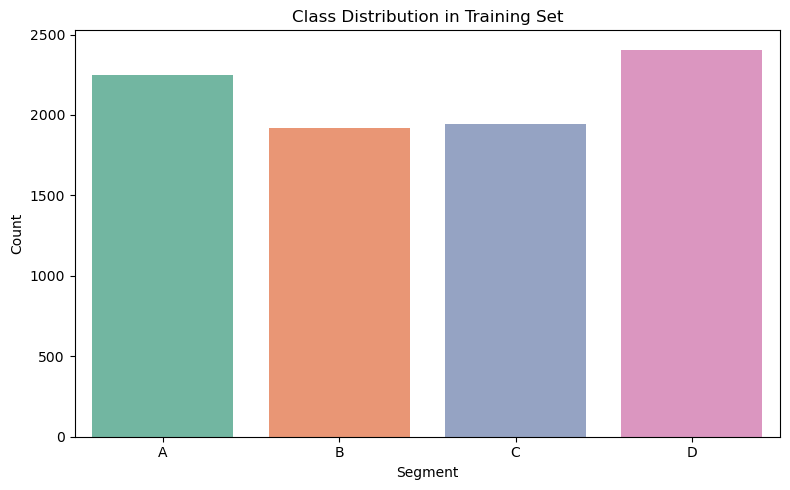

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of instances in each class
class_counts = Dataset_Train['Segmentation'].value_counts()
class_percentages = Dataset_Train['Segmentation'].value_counts(normalize=True) * 100

# Display results
print("🔹 Class Counts:")
print(class_counts)
print("\n🔹 Class Percentages:")
print(class_percentages.round(2))

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Segmentation', data=Dataset_Train, palette='Set2')
plt.title("Class Distribution in Training Set")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


applying SMOTE to balance

In [11]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Assuming your data is already loaded in Dataset_Train
X = Dataset_Train.drop(columns=['Segmentation'])
y = Dataset_Train['Segmentation']

# Split train/test if needed (optional)
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 1. Identify column types
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 2. Preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# 3. Fit preprocessor and transform features
X_processed = preprocessor.fit_transform(X)

# 4. Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

# 5. Optional: Check new class distribution
print("✅ Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Now you can use X_resampled and y_resampled to train your models


✅ Class distribution after SMOTE:
Segmentation
A    2406
B    2406
C    2406
D    2406
Name: count, dtype: int64


🔹 Train Accuracy: 0.7339983374896093
🔹 Test Accuracy : 0.4104127579737336

🔹 Classification Report (Test):

              precision    recall  f1-score   support

           A       0.37      0.33      0.35       563
           B       0.29      0.26      0.28       480
           C       0.43      0.48      0.45       487
           D       0.51      0.55      0.53       602

    accuracy                           0.41      2132
   macro avg       0.40      0.40      0.40      2132
weighted avg       0.40      0.41      0.41      2132



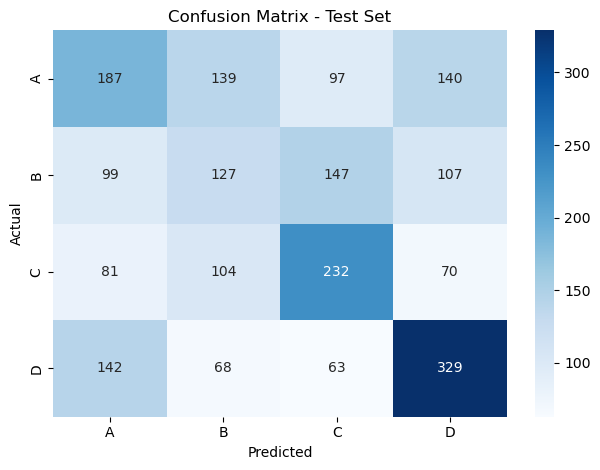

In [12]:
#random forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Step 1: Define target and features
target_col = 'Segmentation'
X_train_raw = Dataset_Train.drop(columns=[target_col])
y_train_raw = Dataset_Train[target_col]
X_test = Dataset_Test.drop(columns=[target_col])
y_test = Dataset_Test[target_col]

# 📌 Step 2: Identify feature types
numeric_cols = X_train_raw.select_dtypes(include='number').columns.tolist()
categorical_cols = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()

# 📌 Step 3: Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# 📌 Step 4: Preprocess training data and apply SMOTE
X_train_processed = preprocessor.fit_transform(X_train_raw)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train_raw)

# 📌 Step 5: Preprocess test data
X_test_processed = preprocessor.transform(X_test)

# 📌 Step 6: Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# 📌 Step 7: Predictions
y_train_pred = rf_model.predict(X_train_resampled)
y_test_pred = rf_model.predict(X_test_processed)

# 📌 Step 8: Evaluation
print("🔹 Train Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("🔹 Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\n🔹 Classification Report (Test):\n")
print(classification_report(y_test, y_test_pred))

# Optional: Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
✅ Train Accuracy: 0.6274937655860349
✅ Test Accuracy : 0.4545028142589118

🔹 Classification Report (Test):

              precision    recall  f1-score   support

           A       0.40      0.39      0.39       563
           B       0.33      0.27      0.30       480
           C       0.49      0.52      0.51       487
           D       0.55      0.61      0.58       602

    accuracy                           0.45      2132
   macro avg       0.44      0.45      0.44      2132
weighted avg       0.45      0.45      0.45      2132



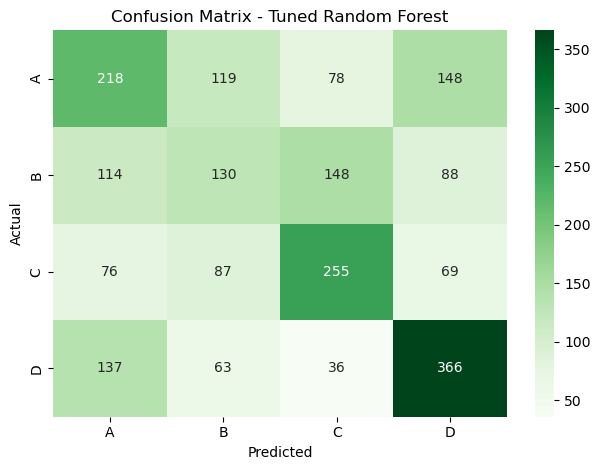

In [13]:
#Hyper parameter tune and fitting random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# Step 2: Preprocess training data
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test)

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train_raw)

# Step 4: Define model and parameter grid
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Step 5: GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_resampled, y_train_resampled)

# Step 6: Best estimator
best_rf = grid_search.best_estimator_

# Step 7: Evaluation
y_train_pred = best_rf.predict(X_train_resampled)
y_test_pred = best_rf.predict(X_test_processed)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Train Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("✅ Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\n🔹 Classification Report (Test):\n")
print(classification_report(y_test, y_test_pred))

# Step 8: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


✅ Train Accuracy: 0.7144868035190616
✅ Test Accuracy : 0.4399624765478424

🔹 Classification Report (Test Data):
              precision    recall  f1-score   support

           A       0.38      0.38      0.38       563
           B       0.34      0.27      0.30       480
           C       0.46      0.45      0.45       487
           D       0.53      0.62      0.57       602

    accuracy                           0.44      2132
   macro avg       0.43      0.43      0.43      2132
weighted avg       0.43      0.44      0.43      2132



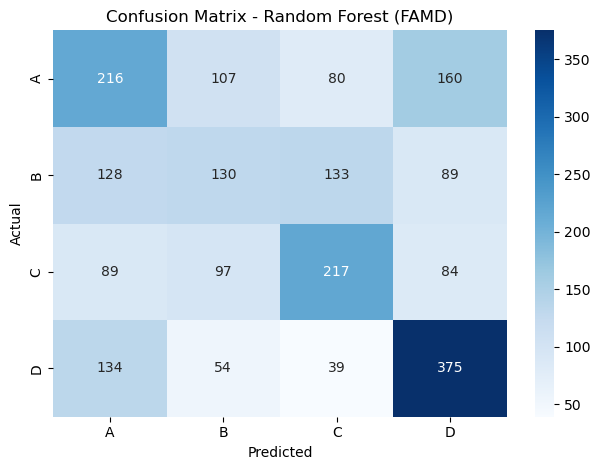

In [ ]:
#Applying FAMD and reducing predictors, fit the random forest
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import prince  # for FAMD

# ✅ 1. Prepare Data
X_train = Dataset_Train.drop(columns=['Segmentation'])
y_train = Dataset_Train['Segmentation']

X_test = Dataset_Test.drop(columns=['Segmentation'])
y_test = Dataset_Test['Segmentation']

# ✅ 2. Combine Train + Test for consistent FAMD transformation
X_all = pd.concat([X_train, X_test], axis=0)
X_all.reset_index(drop=True, inplace=True)

# ✅ 3. Apply FAMD
famd = prince.FAMD(n_components=20, random_state=42)
famd = famd.fit(X_all)

# ✅ 4. Transform train and test separately
X_train_famd = famd.transform(X_train)
X_test_famd = famd.transform(X_test)

# ✅ 5. Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_famd, y_train)

# ✅ 6. Predict
y_train_pred = rf.predict(X_train_famd)
y_test_pred = rf.predict(X_test_famd)

# ✅ 7. Evaluate
print("✅ Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("✅ Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\n🔹 Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

# ✅ 8. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=rf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest (FAMD)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
